In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Introduction

Dungeons and Dragons(DND) is a fantasy Tabletop Role Playing Game (TTRPG) published by Wizards of the Coast. DND utilize "character sheets", a record of a player character's (PC) stats, abilities, and so on. Character sheets are unique to each individual PC, and a character's information is influenced by their class, background, race, etc.

This notebook contains an exploratory data analysis of character sheets submitted to https://oganm.com/shiny/printSheetApp/ and https://oganm.com/shiny/interactiveSheet/, provided on https://github.com/oganm/dnddata under the MIT License.

## Cleaning
This section of the notebook includes reading in the raw data and applying some basic cleaning to make the data easier to work with. 

Some cleaning strategies I used were:
1. Standardizing the race and background columns by removing punctuation and capitalizing each word
2. Splitting strings that contain multiple values into lists (Ex. 'Ranger | Bard' into ['Ranger', 'Bard'])
3. Classifying characters into difficulty to play, class type, and key stats based on all their classes
4. Assigning "primary" class types to multi-class characters based on the class they had the highest level in (Ex. A character with 4 levels in Fighter and 2 in Sorcerer will be assigned Fighter as their primary class)
5. Classifying characters into difficulty to play, class type, and key stats based on their primary class
6. Creating a dictionary keyed by spell level, with the values being the spells for each level for spellcasters

In [2]:
all_fp = os.path.join('data', 'dnd_chars_all.tsv')
alldf = pd.read_csv(all_fp, sep='\t')
alldf = alldf.drop(columns = ['name', 'ip', 'finger', 'hash'])
alldf =  alldf.replace('Revised Ranger', 'Ranger', regex = True)
alldf.head()

,race,background,date,class,justClass,subclass,level,feats,HP,AC,...,country,countryCode,processedAlignment,good,lawful,processedRace,processedSpells,processedWeapons,levelGroup,alias
0,Wood Elf,Custom,2019-04-04T20:58:17Z,Ranger 1,Ranger,NaN,1,NaN,11,13,...,Canada,CA,NaN,NaN,NaN,Elf,NaN,Shortsword|Longbow,1-3,wizardly_dewdney
1,Tiefling,Courtier,2019-04-04T17:47:10Z,Rogue 3,Rogue,Assassin,3,NaN,21,13,...,Canada,CA,NaN,NaN,NaN,Tiefling,NaN,Rapier|Shortbow|Dagger,1-3,optimistic_herschel
2,High Elf,Sage,2019-04-04T17:21:11Z,Wizard 1,Wizard,NaN,1,NaN,8,16,...,United States,US,NN,NaN,NaN,Elf,Toll the Dead*0|Prestidigitation*0|Fire Bolt*0...,Quarterstaff,1-3,blissful_murdock
3,Human,Urchin,2019-04-04T05:49:56Z,Fighter 1,Fighter,NaN,1,Sharpshooter,12,15,...,Canada,CA,LN,NaN,NaN,Human,NaN,"Shortsword|Crossbow, Heavy",1-3,inspiring_swirles
4,Human,Urchin,2019-04-04T04:48:19Z,Fighter 2,Fighter,NaN,2,Sharpshooter,18,15,...,Canada,CA,LN,NaN,NaN,Human,NaN,"Shortsword|Crossbow, Heavy",1-3,inspiring_swirles


In [3]:
uni_fp = os.path.join('data', 'dnd_chars_unique.tsv')
unidf = pd.read_csv(uni_fp, sep='\t')
unidf = unidf.drop(columns = ['name', 'ip', 'finger', 'hash'])
unidf = unidf.replace('Revised Ranger', 'Ranger', regex = True)
unidf.head()

,race,background,date,class,justClass,subclass,level,feats,HP,AC,...,country,countryCode,processedAlignment,good,lawful,processedRace,processedSpells,processedWeapons,levelGroup,alias
0,Human,City Watch,2019-03-30T05:37:21Z,Druid 20,Druid,Circle of Spores,20,Elemental Adept,195,17,...,United States,US,NaN,NaN,NaN,Human,Chill Touch*0,Scimitar,19-20,awesome_jones
1,Human,Noble,2019-03-28T02:52:00Z,Wizard 20,Wizard,School of Enchantment,20,War Caster|Spell Sniper|Resilient,200,14,...,Canada,CA,NaN,NaN,NaN,Human,Fire Bolt*0|Eldritch Blast*0|Tasha's Hideous L...,Quarterstaff,19-20,musing_swanson
2,Human,Sage,2019-03-27T16:09:36Z,Wizard 20,Wizard,School of Necromancy,20,Keen Mind|War Caster|Spell Sniper|Actor|Magic ...,174,13,...,United States,US,NaN,NaN,NaN,Human,Animate Dead*3,Quarterstaff,19-20,relaxed_shtern
3,Eladrin ToF,Acolyte,2019-03-23T22:01:58Z,Sorcerer 20,Sorcerer,Wild Magic,20,Magic Initiate|Elven Accuracy,81,14,...,United States,US,NaN,NaN,NaN,Eladrin,Vicious Mockery*0|Prestidigitation*0|Minor Ill...,Quarterstaff|Dagger,19-20,relaxed_greider
4,Eladrin ToF,Noble,2019-03-23T21:24:39Z,Fighter 20,Fighter,Battle Master,20,NaN,189,16,...,United States,US,NaN,NaN,NaN,Eladrin,NaN,Longbow|Longsword|Handaxe,19-20,silly_babbage


In [4]:
alldf.columns

Index(['race', 'background', 'date', 'class', 'justClass', 'subclass', 'level',
       'feats', 'HP', 'AC', 'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha',
       'alignment', 'skills', 'weapons', 'spells', 'day', 'castingStat',
       'country', 'countryCode', 'processedAlignment', 'good', 'lawful',
       'processedRace', 'processedSpells', 'processedWeapons', 'levelGroup',
       'alias'],
      dtype='object')

In [5]:
typeDict = {'Magical' : set(['Wizard', 'Druid', 'Warlock', 'Sorcerer']),
                  'Combat' : set(['Fighter', 'Barbarian', 'Rogue', 'Monk']),
                  'Hybrid': set(['Bard', 'Ranger', 'Ranger', 'Cleric', 'Paladin'])}

difficultyDict = {'Easy' : set(['Fighter', 'Barbarian', 'Paladin', 'Ranger']),
                  'Medium' : set(['Rogue', 'Cleric', 'Monk', 'Warlock']),
                  'Challenging' : set(['Bard', 'Druid', 'Sorcerer', 'Wizard'])}

statDict = {'Str': set(['Barbarian', 'Fighter', 'Paladin']),
            'Cha': set(['Bard', 'Sorcerer', 'Paladin', 'Warlock']),
            'Wis': set(['Cleric', 'Druid', 'Monk', 'Ranger']),
            'Dex': set(['Monk', 'Fighter', 'Rogue', 'Ranger']),
            'Int': set(['Wizard'])}

In [6]:
def clean_titles(word):
    if not pd.isna(word):
        listed = word.replace('-', ' ').split()
        cleaned = ' '.join(listed)
        cleaned = cleaned.title()
        return cleaned
    else:
        return word

In [7]:
def clean_spells(word):
    if not pd.isna(word):
        spellbook = {}
        listed = word.split('|')
        
        for spell in listed:
            level = spell[-1]
            if level in spellbook.keys():
                spellbook[level].append(spell[:-2])
            else:
                spellbook[level] = [spell[:-2]]
                
        return spellbook
    return np.nan

In [8]:
def clean_misc(col):
    def clean(word):
        if not pd.isna(word):
            return word.split('|')
        return [np.nan]
    return col.apply(clean)

In [9]:
def classify(group, dictionary):
    if any(pd.isnull(group)):
        return np.nan
    grouped = set(group)
    keys = dictionary.keys()
    classification = set()
    for key in keys:
        classes = dictionary[key]
        if grouped.intersection(classes):
            classification.add(key)
    if len(classification) == 1:
        return ''.join(classification)
    return list(classification)

In [10]:
def sort_class(values):
    if not all(pd.isna(values)):
        values.sort(key= lambda x: int(x[-2:].strip(' ')), reverse = True)
        return [values[0][:-2].strip()]
    return [np.nan]

In [11]:
def clean_dataframe(frame):
    df = frame.copy()
    df['race'] = df['race'].apply(clean_titles)
    df['background'] = df['background'].apply(clean_titles)
    
    df['processedSpells'] = df['processedSpells'].apply(clean_spells)
    
    df[['class', 'justClass', 'subclass', 'feats', 'skills', 'processedWeapons']] = \
    df[['class', 'justClass', 'subclass', 'feats', 'skills'
           , 'processedWeapons']].apply(clean_misc)
    
    df['difficulty'] = df['justClass'].apply(classify, dictionary = difficultyDict)
    df['classType'] = df['justClass'].apply(classify, dictionary = typeDict)
    df['keyStats'] = df['justClass'].apply(classify, dictionary = statDict)
    
    df['primaryClass'] = df['class'].apply(sort_class)
    
    df['primaryDifficulty'] = df['primaryClass'].apply(classify, dictionary = difficultyDict)
    df['primaryClassType'] = df['primaryClass'].apply(classify, dictionary = typeDict)
    df['primaryKeyStats'] = df['primaryClass'].apply(classify, dictionary = statDict)
    
    df['primaryClass'] = df['primaryClass'].apply(lambda x: x[0] if not pd.isna(x) else x)
    
    return df

In [12]:
df = clean_dataframe(alldf)
uni_df = clean_dataframe(unidf)

In [13]:
df.head()

,race,background,date,class,justClass,subclass,level,feats,HP,AC,...,processedWeapons,levelGroup,alias,difficulty,classType,keyStats,primaryClass,primaryDifficulty,primaryClassType,primaryKeyStats
0,Wood Elf,Custom,2019-04-04T20:58:17Z,[Ranger 1],[Ranger],[nan],1,[nan],11,13,...,"[Shortsword, Longbow]",1-3,wizardly_dewdney,Easy,Hybrid,"[Wis, Dex]",Ranger,Easy,Hybrid,"[Wis, Dex]"
1,Tiefling,Courtier,2019-04-04T17:47:10Z,[Rogue 3],[Rogue],[Assassin],3,[nan],21,13,...,"[Rapier, Shortbow, Dagger]",1-3,optimistic_herschel,Medium,Combat,Dex,Rogue,Medium,Combat,Dex
2,High Elf,Sage,2019-04-04T17:21:11Z,[Wizard 1],[Wizard],[nan],1,[nan],8,16,...,[Quarterstaff],1-3,blissful_murdock,Challenging,Magical,Int,Wizard,Challenging,Magical,Int
3,Human,Urchin,2019-04-04T05:49:56Z,[Fighter 1],[Fighter],[nan],1,[Sharpshooter],12,15,...,"[Shortsword, Crossbow, Heavy]",1-3,inspiring_swirles,Easy,Combat,"[Str, Dex]",Fighter,Easy,Combat,"[Str, Dex]"
4,Human,Urchin,2019-04-04T04:48:19Z,[Fighter 2],[Fighter],[nan],2,[Sharpshooter],18,15,...,"[Shortsword, Crossbow, Heavy]",1-3,inspiring_swirles,Easy,Combat,"[Str, Dex]",Fighter,Easy,Combat,"[Str, Dex]"


## Exploratory Data Analysis
This section of the notebook includes data visualization, classifications, and data analyses. Potential explored variables are character race, class, and stat distributions.

In [14]:
classes = []
for classifier in df['justClass'].value_counts().index:
    if len(classifier) == 1:
        classes.append(classifier[0])
    if len(classes) == 12:
        break
stats = ['Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha']

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

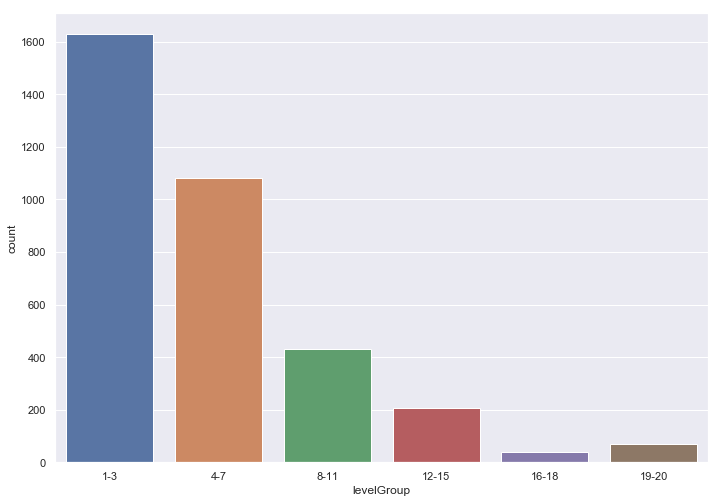

In [16]:
sns.countplot(x = 'levelGroup', data = df.sort_values('level'))

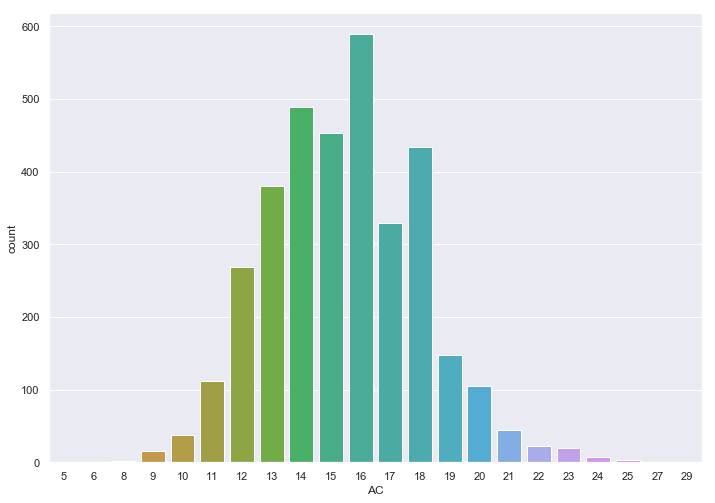

In [17]:
sns.countplot(data = df, x = 'AC')

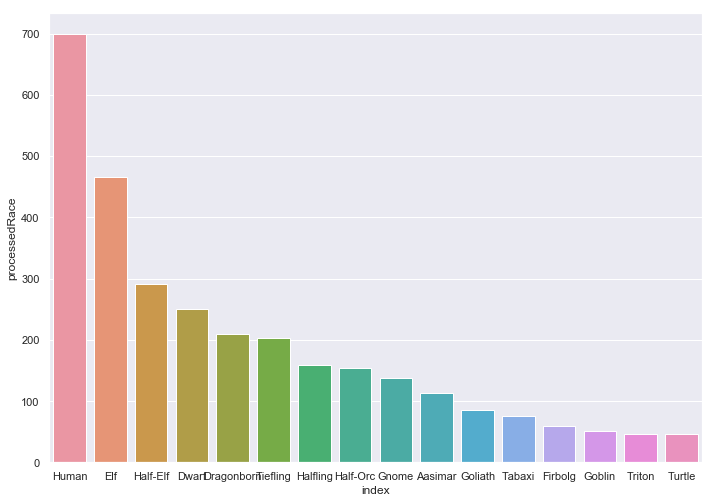

In [18]:
race_count = df['processedRace'].value_counts().to_frame().reset_index()
sns.barplot(data = race_count.loc[race_count['processedRace'] > 40], \
           x = 'index', y = 'processedRace')

In [19]:
csv_all_fp = os.path.join('data', 'cleaned_all.csv')
df.to_csv(csv_all_fp, index=False)

In [20]:
csv_uni_fp = os.path.join('data', 'cleaned_unique.csv')
uni_df.to_csv(csv_uni_fp, index=False)

In [21]:
#df.loc[df['justClass'].str.contains('Ranger', regex = False, na = False)]

In [22]:
#TODO: join class strings, divide into class types (magic, martial, etc)

In [23]:
df.head()

,race,background,date,class,justClass,subclass,level,feats,HP,AC,...,processedWeapons,levelGroup,alias,difficulty,classType,keyStats,primaryClass,primaryDifficulty,primaryClassType,primaryKeyStats
0,Wood Elf,Custom,2019-04-04T20:58:17Z,[Ranger 1],[Ranger],[nan],1,[nan],11,13,...,"[Shortsword, Longbow]",1-3,wizardly_dewdney,Easy,Hybrid,"[Wis, Dex]",Ranger,Easy,Hybrid,"[Wis, Dex]"
1,Tiefling,Courtier,2019-04-04T17:47:10Z,[Rogue 3],[Rogue],[Assassin],3,[nan],21,13,...,"[Rapier, Shortbow, Dagger]",1-3,optimistic_herschel,Medium,Combat,Dex,Rogue,Medium,Combat,Dex
2,High Elf,Sage,2019-04-04T17:21:11Z,[Wizard 1],[Wizard],[nan],1,[nan],8,16,...,[Quarterstaff],1-3,blissful_murdock,Challenging,Magical,Int,Wizard,Challenging,Magical,Int
3,Human,Urchin,2019-04-04T05:49:56Z,[Fighter 1],[Fighter],[nan],1,[Sharpshooter],12,15,...,"[Shortsword, Crossbow, Heavy]",1-3,inspiring_swirles,Easy,Combat,"[Str, Dex]",Fighter,Easy,Combat,"[Str, Dex]"
4,Human,Urchin,2019-04-04T04:48:19Z,[Fighter 2],[Fighter],[nan],2,[Sharpshooter],18,15,...,"[Shortsword, Crossbow, Heavy]",1-3,inspiring_swirles,Easy,Combat,"[Str, Dex]",Fighter,Easy,Combat,"[Str, Dex]"


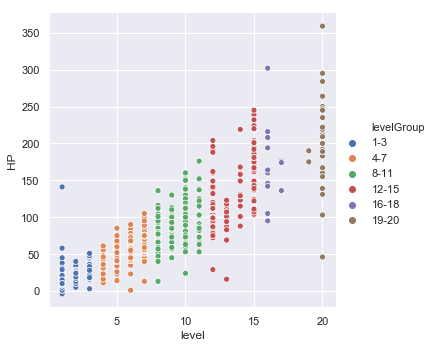

In [24]:
combat = df.loc[df['classType'].str.contains('Combat', regex = False, na = False)]
sns.relplot(x = "level", y = 'HP',  data=combat.sort_values('level'), hue = 'levelGroup')

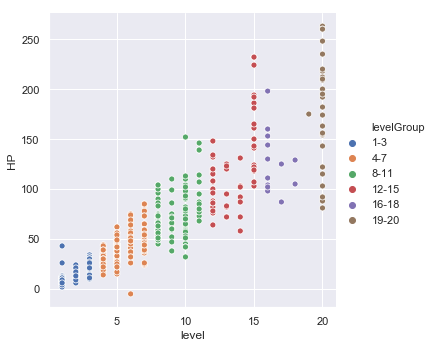

In [25]:
magical = df.loc[df['classType'].str.contains('Magical', regex = False, na = False)]
sns.relplot(x = "level", y = 'HP',  data= magical.sort_values('level'), hue = 'levelGroup')

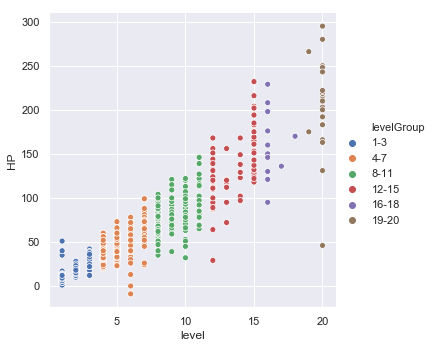

In [26]:
hybrid = df.loc[df['classType'].str.contains('Hybrid', regex = False, na = False)]
sns.relplot(x = "level", y = 'HP',  data= hybrid.sort_values('level'), hue = 'levelGroup')

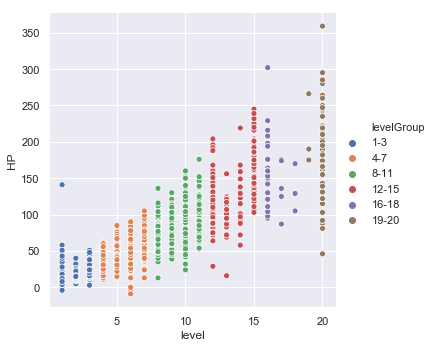

In [27]:
sns.relplot(x = 'level', y = 'HP', data = df.sort_values('level')\
            .loc[(df['level'] > 0) & (df['level'] <= 20)],
            hue = 'levelGroup')

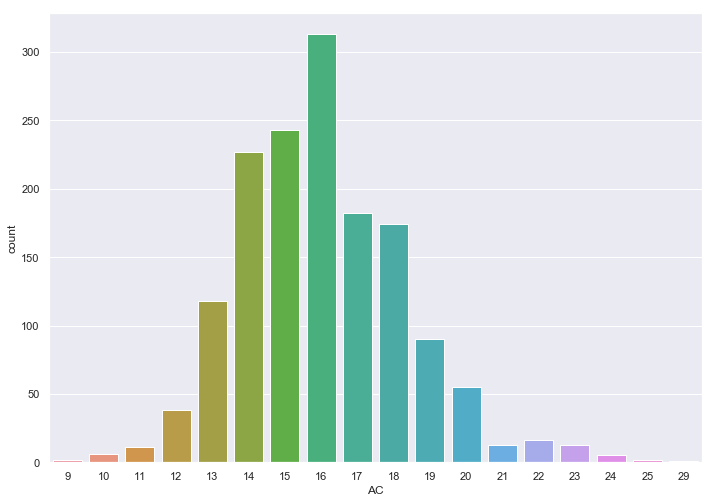

In [28]:
combat_count = combat['processedRace'].value_counts().to_frame().reset_index()
#combat_plot = sns.barplot(data = combat_count.loc[race_count['processedRace'] > 50], \
#           x = 'index', y = 'processedRace')
#combat_plot.set(xlabel='race', ylabel='count')
sns.countplot(data = combat, x = 'AC')

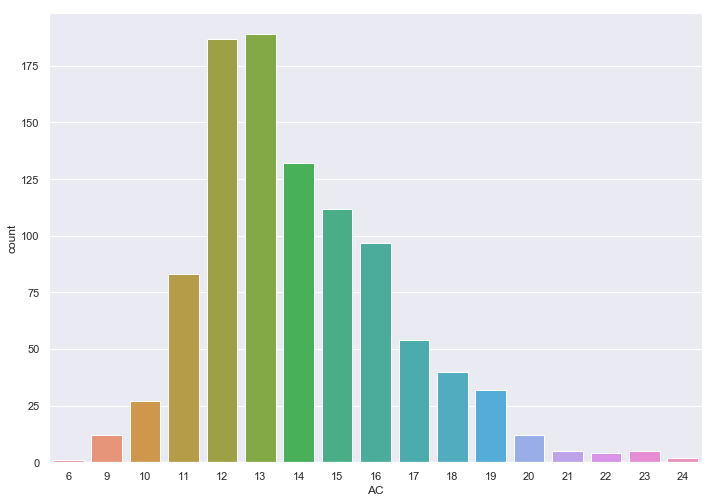

In [29]:
magic_count = magical['processedRace'].value_counts().to_frame().reset_index()
#magic_plot = sns.barplot(data = magic_count.loc[race_count['processedRace'] > 50], \
#           x = 'index', y = 'processedRace')
#magic_plot.set(xlabel='race', ylabel='count')
sns.countplot(data = magical, x = 'AC')

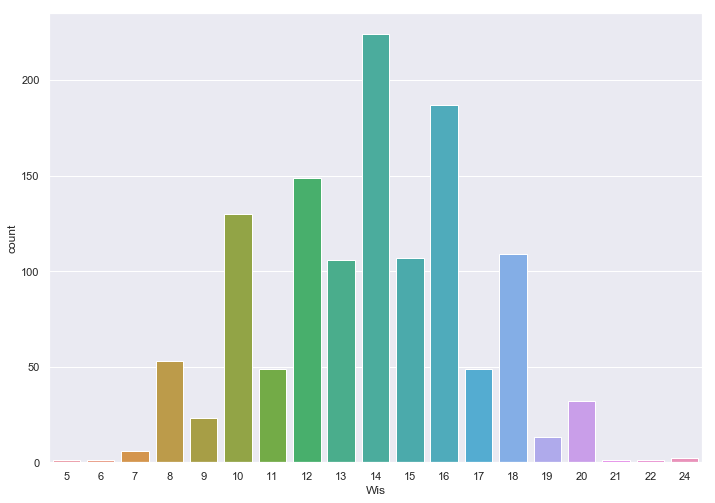

In [30]:
hybrid_count = hybrid['processedRace'].value_counts().to_frame().reset_index()
#hybrid_plot = sns.barplot(data = hybrid_count.loc[race_count['processedRace'] > 50], \
#           x = 'index', y = 'processedRace')
#hybrid_plot.set(xlabel='race', ylabel='count')
sns.countplot(data = hybrid, x = 'Wis')

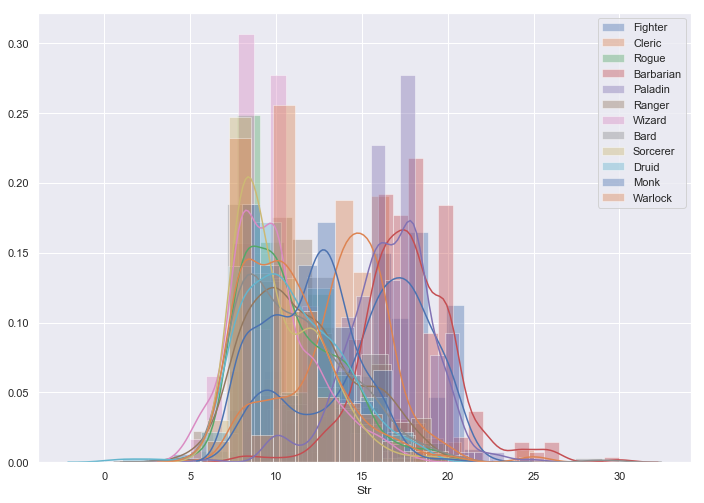

In [31]:
for each in classes:
    classed = df.loc[df['primaryClass'] == each]
    sns.distplot(classed['Str'] , label = each)
plt.legend()

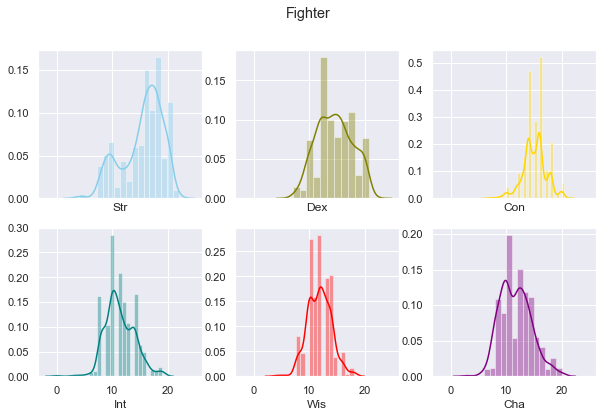

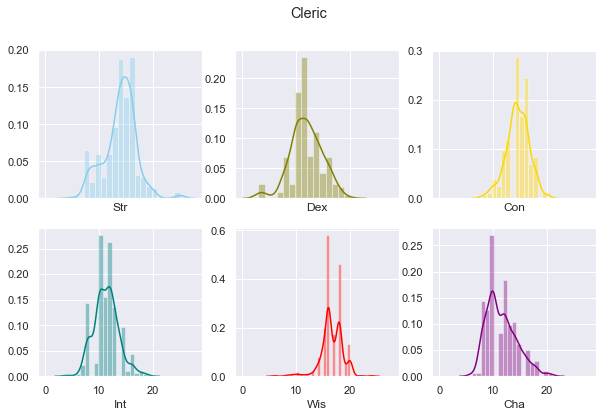

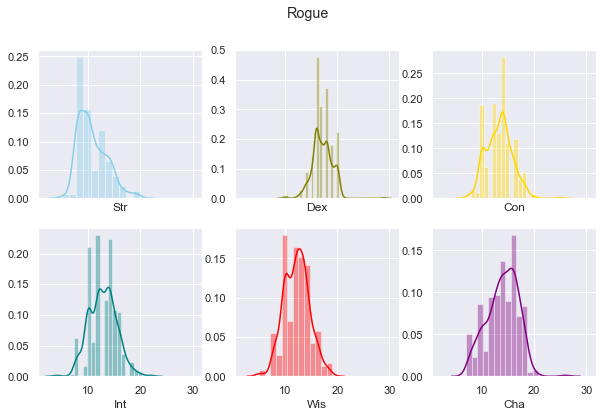

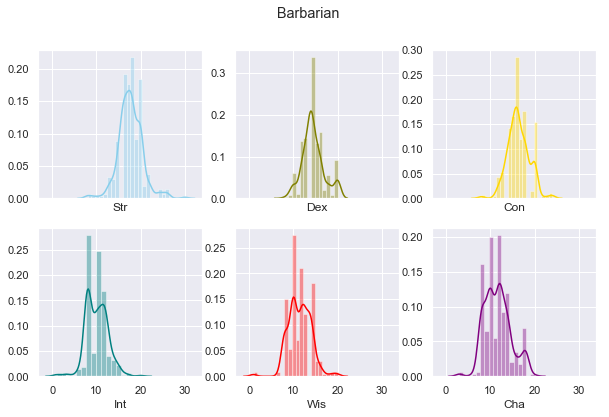

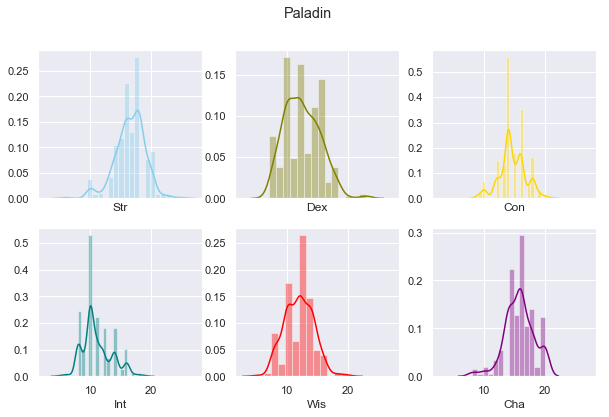

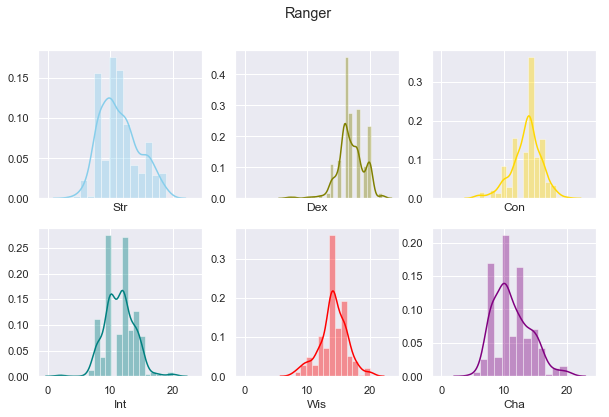

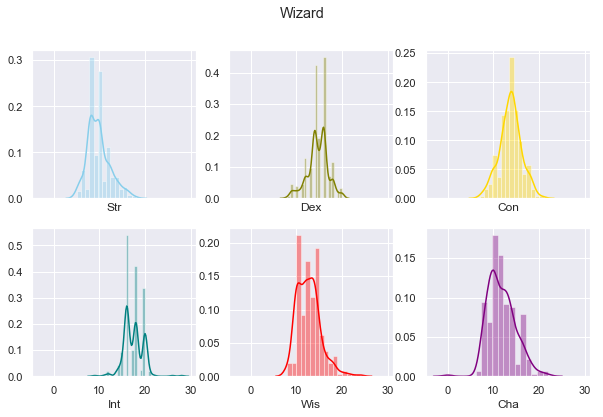

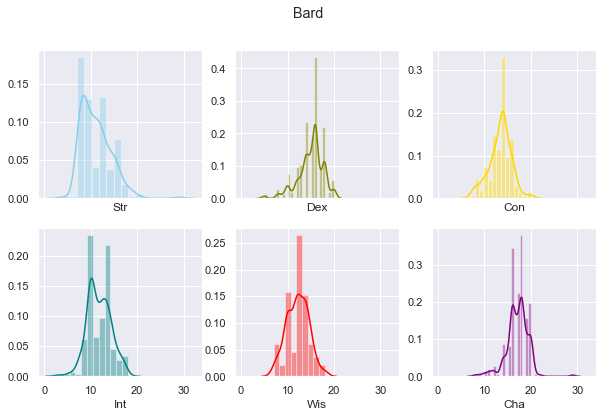

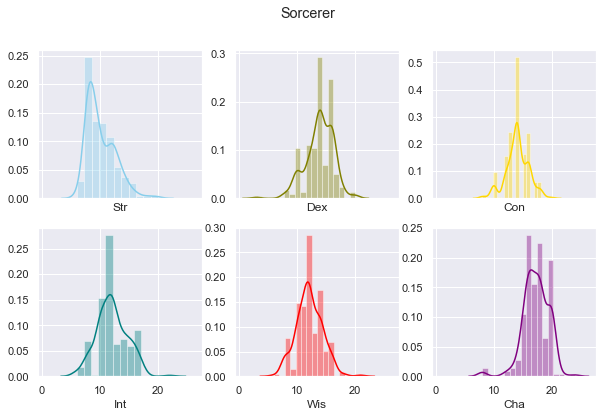

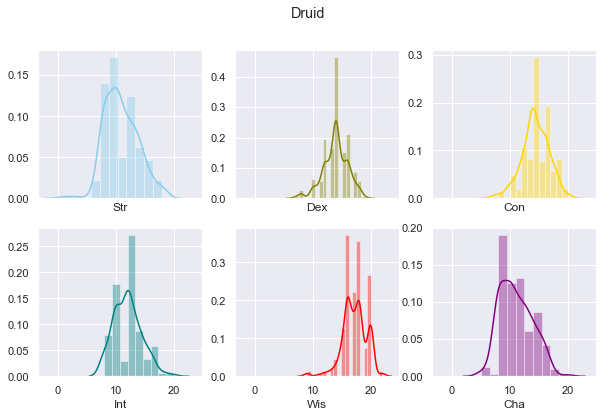

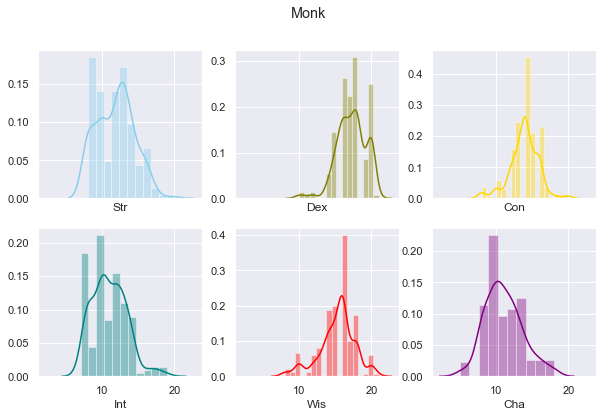

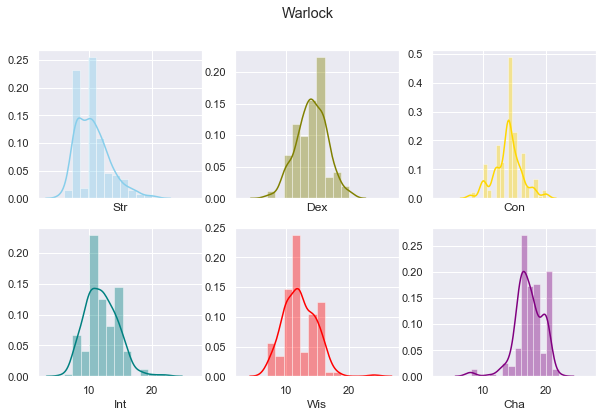

In [32]:
for each in classes:
    classed = df.loc[df['primaryClass'] == each]
    fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

    sns.distplot(classed["Str"], color="skyblue", ax=axes[0, 0])
    sns.distplot(classed["Dex"] , color="olive", ax=axes[0, 1])
    sns.distplot(classed["Con"] , color="gold", ax=axes[0, 2])
    sns.distplot(classed["Int"] , color="teal", ax=axes[1, 0])
    sns.distplot(classed["Wis"] , color="red", ax=axes[1, 1])
    sns.distplot(classed["Cha"] , color="purple", ax=axes[1, 2])
    
    fig.suptitle(each)
    plt.show()